In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-turbine-scada-dataset/T1.csv


### <font color= 'green' > **Import Libraries**

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

### <font color= 'green' > Read the Dataset 

In [3]:
wind_data = pd.read_csv("/kaggle/input/wind-turbine-scada-dataset/T1.csv")
print("five Row of Dataset:")
print(wind_data.head())

five Row of Dataset:
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  


### <font color= 'green' >Overview Of the Dataset 

In [4]:
wind_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
wind_data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


### <font color= 'green' > Adding Target Column 

In [54]:
# Adding new column named 'Power_Level'
# LV ActivePower (kW) divided into three parts: 'low', 'medium', 'high'
wind_data['Power_Level'] = pd.qcut(
    wind_data['LV ActivePower (kW)'],
    q=3,
    labels=['low', 'medium', 'high']
)
print("New 'Power_Level' Column with Five Rows:")
print(wind_data.head())

New 'Power_Level' Column with Five Rows:
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°) Power_Level  
0                     416.328908          259.994904      medium  
1                     519.917511          268.641113      medium  
2                     390.900016          272.564789      medium  
3                     516.127569          271.258087      medium  
4                     491.702972          265.674286      medium  


In [55]:
wind_data['Power_Level']

0        medium
1        medium
2        medium
3        medium
4        medium
          ...  
50525      high
50526    medium
50527      high
50528      high
50529      high
Name: Power_Level, Length: 50530, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

### <font color= 'green' >Negative value correction

* The 'LV ActivePower (kW)' column contains negative values, which is physically impossible for a wind turbine's power output. These values are typically caused by sensor errors or indicate that the turbine is in an idle state and not producing power.

* To maintain the physical integrity of the data and ensure a robust model, these negative values are replaced with 0. This is the most logical and justifiable approach for this type of data.

In [56]:
wind_data['LV ActivePower (kW)'] = wind_data['LV ActivePower (kW)'].apply(lambda x: 0 if x < 0 else x)

### <font color= 'green' > Overview of the Dataset 

In [57]:
# Data size , column , Data type 
print("Data Primary Information")
wind_data.info()


print("\nData Overview:")
print(wind_data.describe())

Data Primary Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Date/Time                      50530 non-null  object  
 1   LV ActivePower (kW)            50530 non-null  float64 
 2   Wind Speed (m/s)               50530 non-null  float64 
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64 
 4   Wind Direction (°)             50530 non-null  float64 
 5   Power_Level                    50530 non-null  category
dtypes: category(1), float64(4), object(1)
memory usage: 2.0+ MB

Data Overview:
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684699          7.557952                    1492.175463   
std            1312.458876          4.227166                 

### <font color= 'green' > Check Missing Values 

In [58]:
# Missing Values 
print("\nNumber of Missing Values in each column:")
print(wind_data.isnull().sum())


Number of Missing Values in each column:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Power_Level                      0
dtype: int64


### <font color= 'green' >Exploratory Data Analysis (EDA)

### <font color= 'green' > Distribution of All Features

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


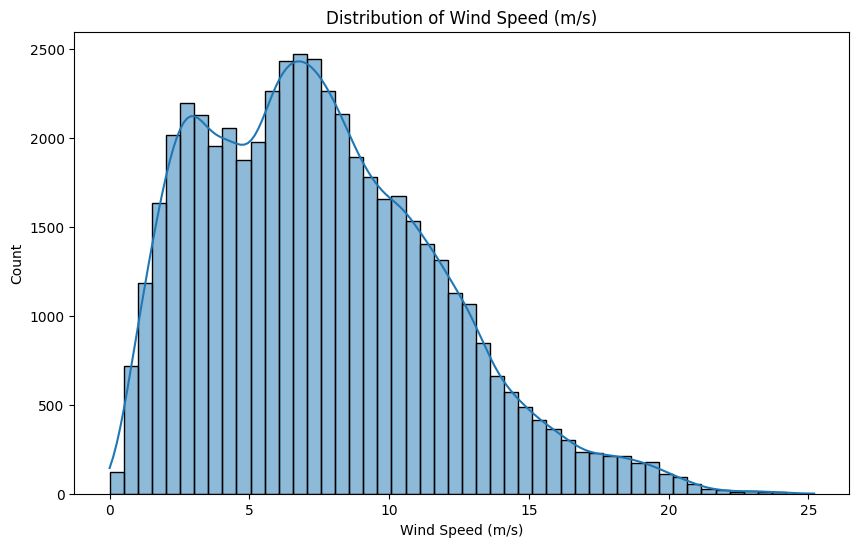

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


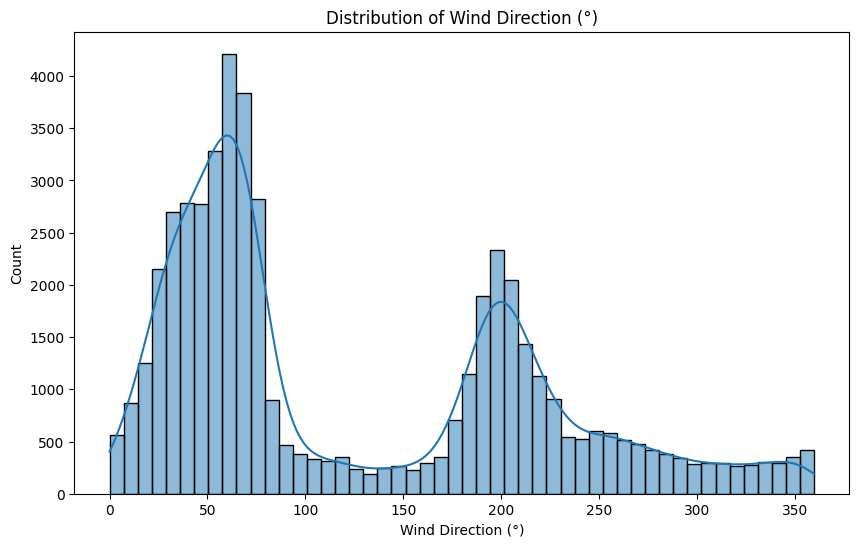

In [59]:
# Distribution of Wind Speed (m/s)
plt.figure(figsize=(10, 6))
sns.histplot(wind_data['Wind Speed (m/s)'], kde=True, bins=50)
plt.title('Distribution of Wind Speed (m/s)')
plt.show()

# Distribution of Wind Direction (°)
plt.figure(figsize=(10, 6))
sns.histplot(wind_data['Wind Direction (°)'], kde=True, bins=50)
plt.title('Distribution of Wind Direction (°)')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

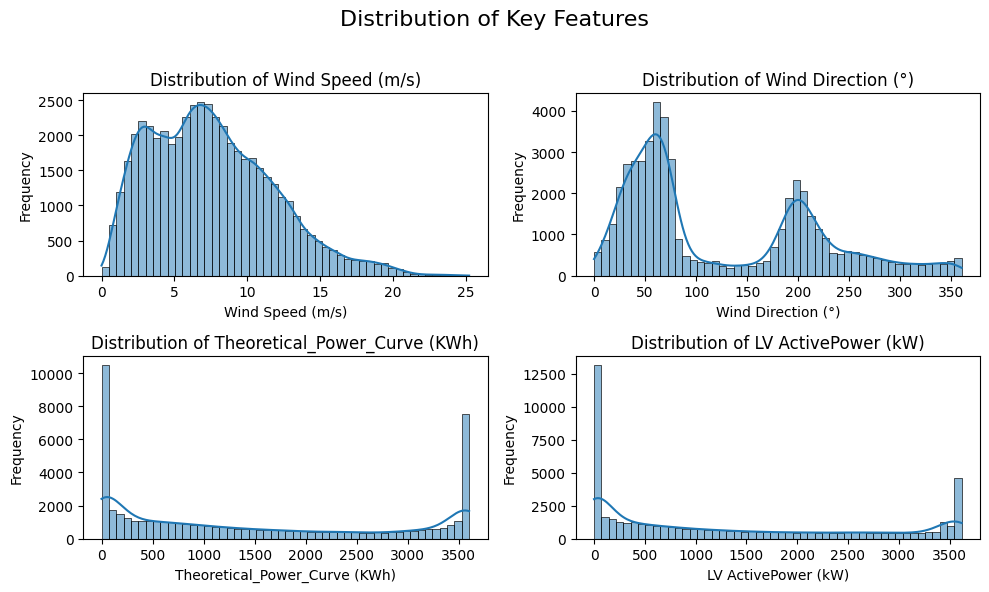

All feature distribution plots have been generated and saved in a single file.


In [60]:
features_to_plot = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)', 'LV ActivePower (kW)']

# 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.suptitle('Distribution of Key Features', fontsize=16)

# Distribution for all features 
for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    
    sns.histplot(wind_data[feature], kde=True, bins=50, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.savefig(r"D:\All feature distribution.png", dpi=300)  # dpi=300 for high quality)
plt.show()

print("All feature distribution plots have been generated and saved in a single file.")

### <font color= 'green'>Distribution of Power_Level Classes

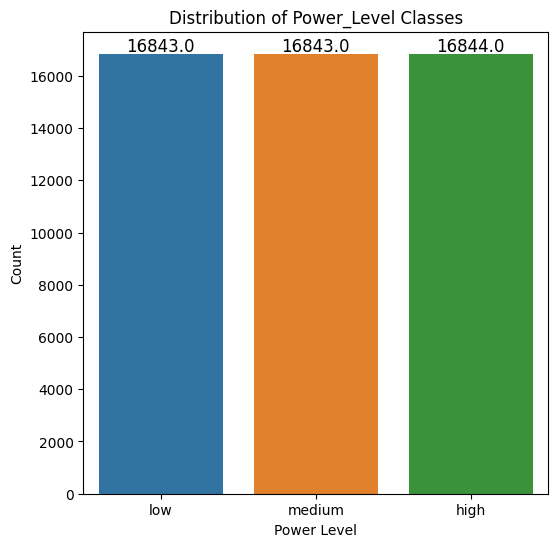


Power_Level Classes and their counts:
Power_Level
high      16844
low       16843
medium    16843
Name: count, dtype: int64


In [62]:
# Plotting with numbers
plt.figure(figsize=(6, 6))
ax = sns.countplot(x='Power_Level', data=wind_data)
plt.title('Distribution of Power_Level Classes')
plt.xlabel('Power Level')
plt.ylabel('Count')

# Add the count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.savefig(r"D:\Distribution.png", dpi=300)  # dpi=300 for high quality
plt.show()

# print the exact counts in the console
print("\nPower_Level Classes and their counts:")
print(wind_data['Power_Level'].value_counts())

### <font color = "green"> Relationship between Wind Speed and LV ActivePower, Correlation Matrix

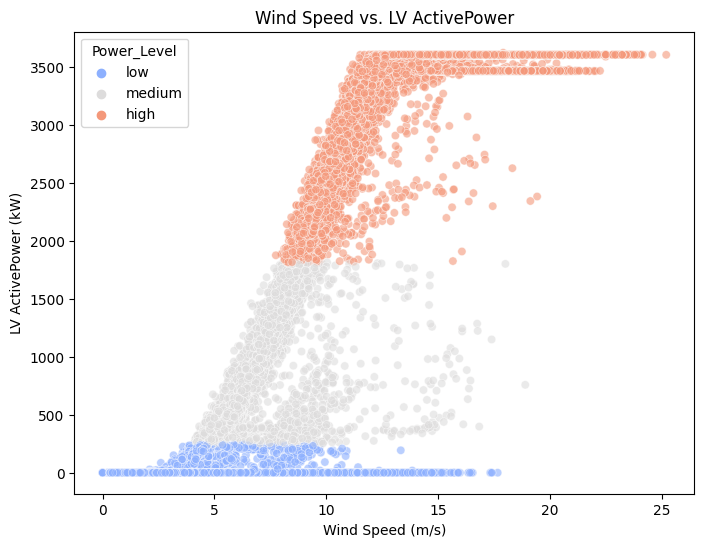

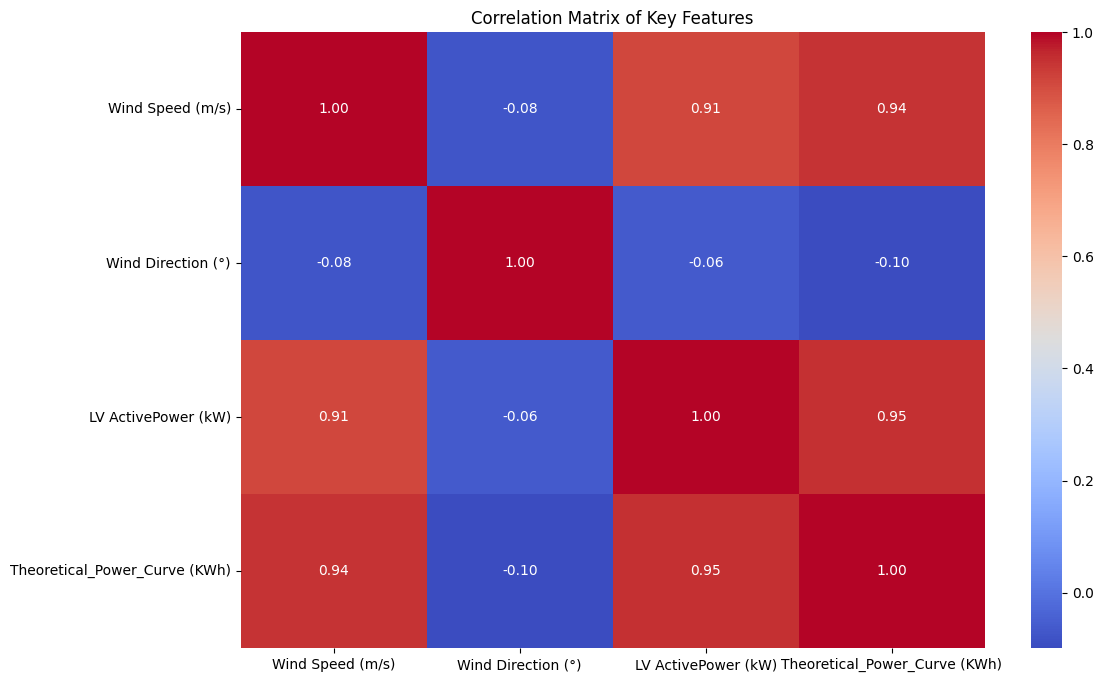

In [63]:
# Relationship between Wind Speed and LV ActivePower
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', hue='Power_Level', data=wind_data, palette='coolwarm', alpha=0.6)
plt.title('Wind Speed vs. LV ActivePower')
plt.savefig(r"D:\wind.png", dpi=300)  # dpi=300 for high quality
plt.show()

# Correlation Matrix 
# Correlation Matrix shows how related one feature with another 
correlation_matrix = wind_data[['Wind Speed (m/s)', 'Wind Direction (°)', 'LV ActivePower (kW)', 'Theoretical_Power_Curve (KWh)']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.savefig(r"D:\corelation.png", dpi=300)  # dpi=300 for high quality
plt.show()

### <font color = "green"> Outliers Detection and Handling 

* A box plot shows the ouliers exist or not 

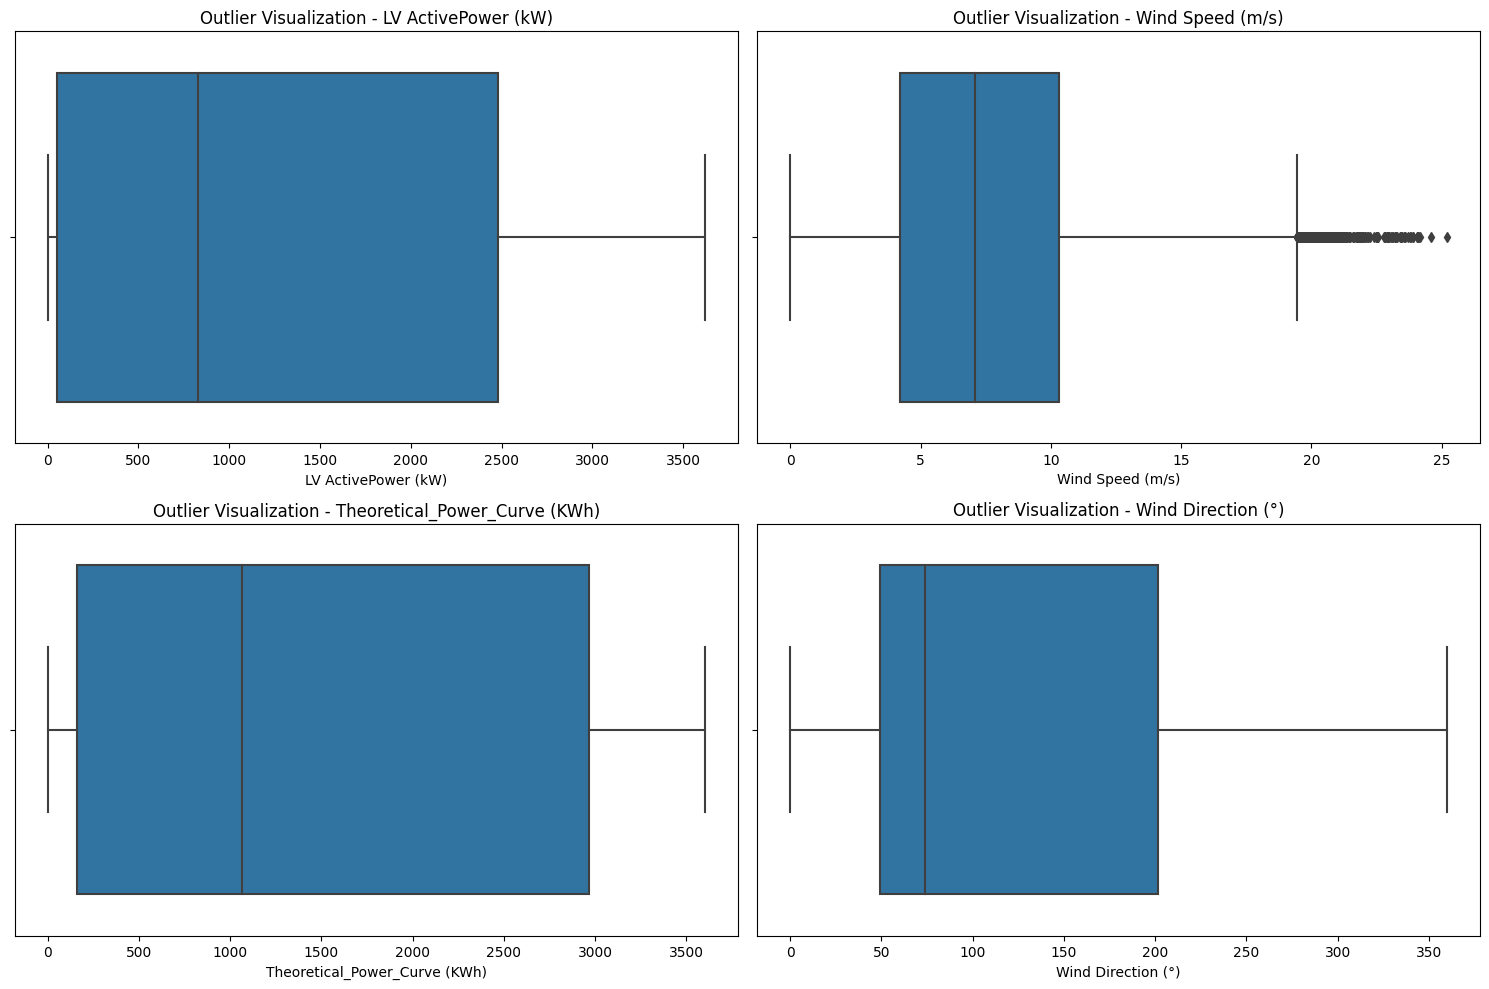

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a figure with four subplots in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot 1: LV ActivePower (kW)
sns.boxplot(x=wind_data['LV ActivePower (kW)'], ax=axes[0])
axes[0].set_title('Outlier Visualization - LV ActivePower (kW)')
axes[0].set_xlabel('LV ActivePower (kW)')

# Plot 2: Wind Speed (m/s)
sns.boxplot(x=wind_data['Wind Speed (m/s)'], ax=axes[1])
axes[1].set_title('Outlier Visualization - Wind Speed (m/s)')
axes[1].set_xlabel('Wind Speed (m/s)')

# Plot 3: Theoretical_Power_Curve (KWh)
sns.boxplot(x=wind_data['Theoretical_Power_Curve (KWh)'], ax=axes[2])
axes[2].set_title('Outlier Visualization - Theoretical_Power_Curve (KWh)')
axes[2].set_xlabel('Theoretical_Power_Curve (KWh)')

# Plot 4: Wind Direction (°)
sns.boxplot(x=wind_data['Wind Direction (°)'], ax=axes[3])
axes[3].set_title('Outlier Visualization - Wind Direction (°)')
axes[3].set_xlabel('Wind Direction (°)')

plt.tight_layout() # Ensures that the plots do not overlap
plt.savefig(r"D:\outliers.png", dpi=300)  # dpi=300 for high quality
plt.show()

* Outliers are data points that are significantly different from the majority of the data. They can distort statistical analysis and negatively impact the performance of machine learning models.

* In this study, we use the **Interquartile Range (IQR) method** to identify and handle outliers in the 'Wind Speed (m/s)' feature. The IQR method is a robust technique that defines outliers as any data point below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

* To prevent these outliers from unduly influencing the model, we employ a capping strategy. Data points exceeding the upper bound are replaced with the upper bound value. This approach helps to stabilize the model without discarding potentially valuable data.

In [66]:

numerical_columns = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

print("Counting Outliers Using IQR\n")

for column in numerical_columns:
    # Q1 (25th percentile) and Q3 (75th percentile) computation 
    Q1 = wind_data[column].quantile(0.25)
    Q3 = wind_data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper boundary
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Counting the outliers that are below the lower bound and above the upper bound
    outliers = wind_data[(wind_data[column] < lower_bound) | (wind_data[column] > upper_bound)]
    
    print(f"'{column}' Number of Outliers: {len(outliers)}")
    
    # First Five outliers 
    if not outliers.empty:
        print(f"Value of First Five Outliers:\n{outliers[[column, 'Date/Time']].head()}")
    print("-" * 50)

Counting Outliers Using IQR

'LV ActivePower (kW)' Number of Outliers: 0
--------------------------------------------------
'Wind Speed (m/s)' Number of Outliers: 423
Value of First Five Outliers:
      Wind Speed (m/s)         Date/Time
2396         19.589029  17 01 2018 19:00
2407         20.408730  17 01 2018 20:50
2408         20.311640  17 01 2018 21:00
2409         20.203560  17 01 2018 21:10
2410         21.735920  17 01 2018 21:20
--------------------------------------------------
'Theoretical_Power_Curve (KWh)' Number of Outliers: 0
--------------------------------------------------
'Wind Direction (°)' Number of Outliers: 0
--------------------------------------------------


* There are **423** ouliers present in **"Wind Speed (m/s)"** column

In [67]:
# --- Outlier capping for 'Wind Speed (m/s)' column ---

# Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
Q1 = wind_data['Wind Speed (m/s)'].quantile(0.25)
Q3 = wind_data['Wind Speed (m/s)'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper bound for outliers
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers
# Any value greater than the upper bound is replaced with the upper bound
wind_data['Wind Speed (m/s)'] = np.where(
    wind_data['Wind Speed (m/s)'] > upper_bound,
    upper_bound,
    wind_data['Wind Speed (m/s)']
)

# --- Verification of the capping process ---

print("After Capping Outliers 'Wind Speed (m/s)' columns statistical summary")
print(wind_data['Wind Speed (m/s)'].describe())

# Recalculate outliers using the same IQR method to confirm they are gone
# Note: Q1, Q3, and IQR remain the same since capping only affects the upper tail
new_outliers = wind_data[
    (wind_data['Wind Speed (m/s)'] < (Q1 - 1.5 * IQR)) |
    (wind_data['Wind Speed (m/s)'] > (Q3 + 1.5 * IQR))
]
print(f"\nNumber of Outliers After Capping them in 'Wind Speed (m/s)' Column: {len(new_outliers)}")

After Capping Outliers 'Wind Speed (m/s)' columns statistical summary
count    50530.000000
mean         7.547758
std          4.195567
min          0.000000
25%          4.201395
50%          7.104594
75%         10.300020
max         19.447957
Name: Wind Speed (m/s), dtype: float64

Number of Outliers After Capping them in 'Wind Speed (m/s)' Column: 0


* Now outliers are removed and the dataset are cleaned

### <font color = "green "> Define the Features and Target Variable 

In [68]:
# Define Feature X and Target Y
X = wind_data[['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']]
y = wind_data['Power_Level']

### <font color = "green">Feature Normalization Using StandardScaler

* Feature normalization, or scaling, is an essential preprocessing step for many machine learning algorithms. Models like Logistic Regression, Support Vector Machines (SVM), and Neural Networks (MLP) are highly sensitive to the magnitude and scale of input features. If features are on different scales, the model may incorrectly give more importance to features with larger values.

* Here, we use `StandardScaler` from scikit-learn. This technique standardizes features by removing the mean and scaling them to have a unit variance. The formula for standardization is:
$z = (x - u) / s$
where $u$ is the mean of the training samples and $s$ is the standard deviation.

* By scaling the features, we ensure that each feature contributes equally to the model's objective function, leading to faster convergence and better overall model performance.

In [69]:
# Feature Normalization Using StandardScaler
# Normalization helps to improve model performance 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### <font color = "green"> Data Preprocessing: Encoding Target Lebel using LabelEncoder


* Most machine learning algorithms are designed to work with numerical data. Our target variable, 'Power_Level', is a categorical feature with labels 'low', 'medium', and 'high'. To make this data compatible with our models, we need to convert these text labels into a numerical format.

* For this purpose, we use `LabelEncoder` from scikit-learn. `LabelEncoder` assigns a unique integer to each unique category in the target column.
  - 'high' will be encoded as 0
  - 'low' will be encoded as 1
  - 'medium' will be encoded as 2

* This conversion allows the models to process the target variable effectively without introducing any artificial ordinal relationship between the categories.

In [70]:
# Encoding Target Lebel using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nEncoded Target Level:", le.classes_)


Encoded Target Level: ['high' 'low' 'medium']


### <font color = 'green' > Data Splitting 

* The dataset is splitting into 80-20 ratio where 80% data will be used for trainig and 20 % for testing 

In [71]:
# 80% for Traing and 20% for Testing 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"\nShape of Train data: {X_train.shape}")
print(f"Shape of Test data: {X_test.shape}")
print(f"Shape of Test data: {y_train.shape}")
print(f"Shape of Test data: {y_test.shape}")


Shape of Train data: (40424, 3)
Shape of Test data: (10106, 3)
Shape of Test data: (40424,)
Shape of Test data: (10106,)


### <font color = 'green' > Model Evaluation and Confusion Matrix 


===== Logistic Regression Model Evaluation =====
Accuracy: 0.9177
Classification Report:
              precision    recall  f1-score   support

        high       0.90      0.99      0.94      3369
         low       0.97      0.86      0.91      3369
      medium       0.89      0.91      0.90      3368

    accuracy                           0.92     10106
   macro avg       0.92      0.92      0.92     10106
weighted avg       0.92      0.92      0.92     10106



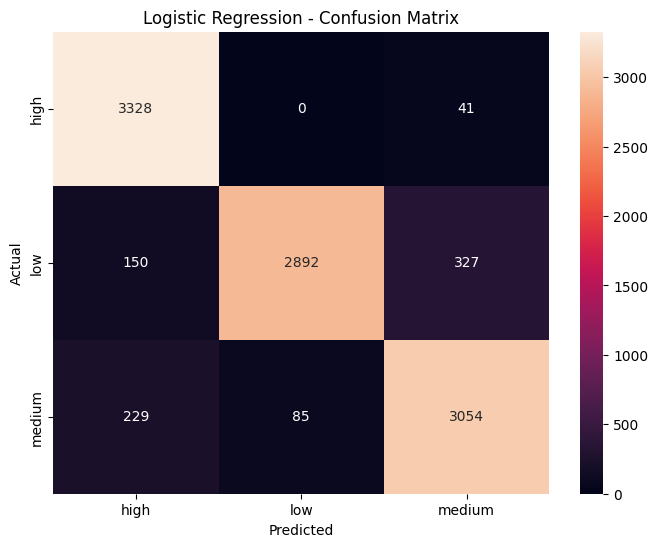


===== Random Forest Model Evaluation =====
Accuracy: 0.9277
Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.97      0.94      3369
         low       0.97      0.88      0.92      3369
      medium       0.89      0.94      0.92      3368

    accuracy                           0.93     10106
   macro avg       0.93      0.93      0.93     10106
weighted avg       0.93      0.93      0.93     10106



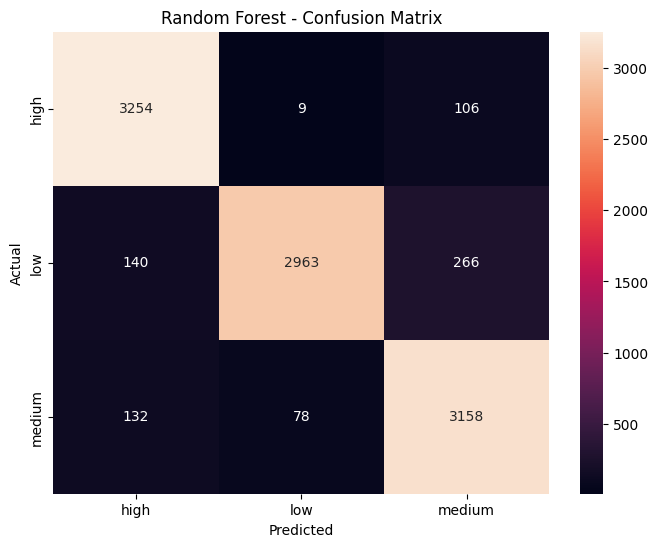


===== Gradient Boosting Model Evaluation =====
Accuracy: 0.9348
Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.98      0.95      3369
         low       0.98      0.88      0.93      3369
      medium       0.91      0.94      0.93      3368

    accuracy                           0.93     10106
   macro avg       0.94      0.93      0.93     10106
weighted avg       0.94      0.93      0.93     10106



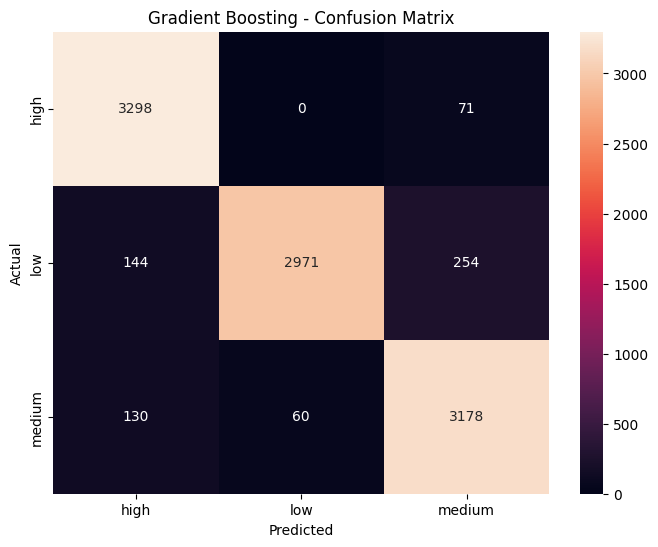


===== MLP Classifier (Neural Network) Model Evaluation =====
Accuracy: 0.9335
Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.98      0.95      3369
         low       0.98      0.88      0.93      3369
      medium       0.90      0.95      0.92      3368

    accuracy                           0.93     10106
   macro avg       0.94      0.93      0.93     10106
weighted avg       0.94      0.93      0.93     10106



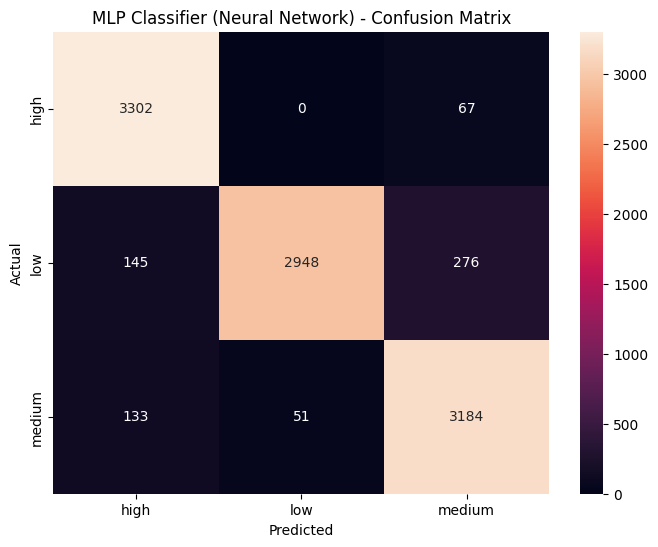

In [72]:
# Dictionary for several model
models = {
    'Logistic Regression': LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP Classifier (Neural Network)': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

# Train and Evaluation for All model
for name, model in models.items():
    print(f"\n===== {name} Model Evaluation =====")
    
    # Model Training
    model.fit(X_train, y_train)

    # Prediction on test data 
    y_pred = model.predict(X_test)

    # Print the Result 
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


===== XGBoost Classifier Model Evaluation =====
Accuracy: 0.9323
Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.97      0.95      3369
         low       0.98      0.88      0.93      3369
      medium       0.90      0.95      0.92      3368

    accuracy                           0.93     10106
   macro avg       0.93      0.93      0.93     10106
weighted avg       0.93      0.93      0.93     10106



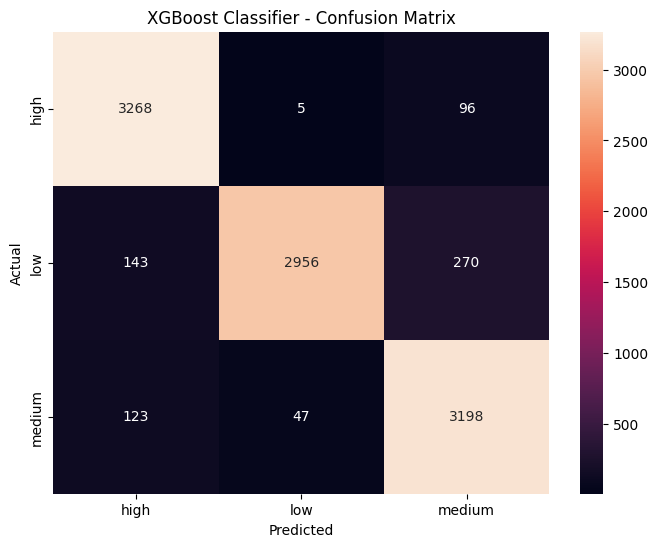

In [73]:
# XGBoost model
name = 'XGBoost Classifier'
print(f"\n===== {name} Model Evaluation =====")

# Model Making
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Model Traing 
xgb_model.fit(X_train, y_train)

# Prediction on Test Data 
y_pred = xgb_model.predict(X_test)

# Print the result 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"{name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### <font color = 'green' > Feature Importance Analysis 


* Feature importance analysis is a crucial step in machine learning to understand the "why" behind a model's predictions. It provides insights into which input features contribute most to the model's output, thereby enhancing the interpretability and trustworthiness of the model.

* For tree-based models like Random Forest, Gradient Boosting, and XGBoost, we can directly access the `feature_importances_` attribute. This attribute returns a score for each feature, indicating its relative importance in making predictions. A higher score signifies a greater influence on the model's outcome.

* For linear models like Logistic Regression, we analyze the absolute values of the model's coefficients (`coef_`). A larger coefficient (positive or negative) indicates a stronger relationship between the feature and the target variable.

* In the case of neural networks like MLP, there is no direct `feature_importances_` attribute. However, we can use a proxy by analyzing the weights from the first hidden layer. By calculating the mean absolute value of these weights for each input feature, we can get an approximate measure of its importance.

* By analyzing feature importance across all models, we can gain a deeper understanding of the underlying dynamics of the wind turbine data and validate the key factors influencing power level.


===== Random Forest - Feature Importance Analysis =====
                         Feature  Importance
0               Wind Speed (m/s)    0.472643
2  Theoretical_Power_Curve (KWh)    0.430871
1             Wind Direction (°)    0.096486


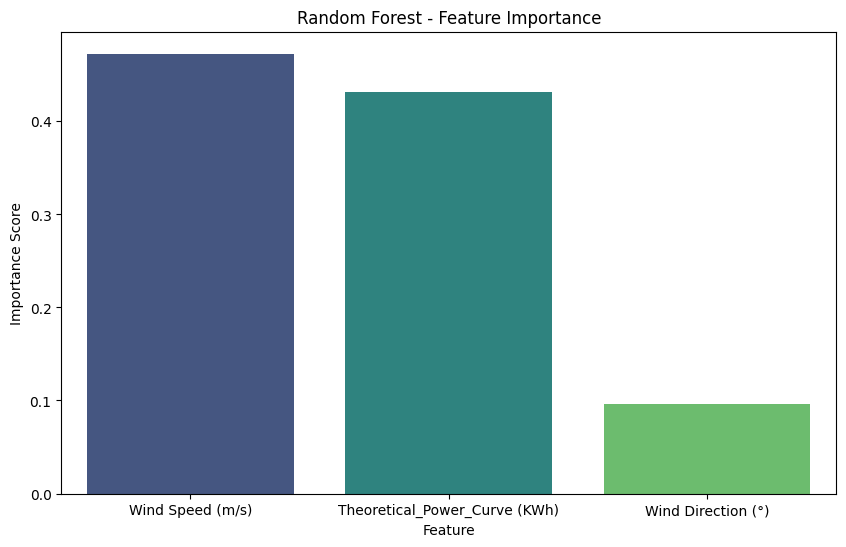


===== Gradient Boosting - Feature Importance Analysis =====
                         Feature  Importance
0               Wind Speed (m/s)    0.555730
2  Theoretical_Power_Curve (KWh)    0.432226
1             Wind Direction (°)    0.012044


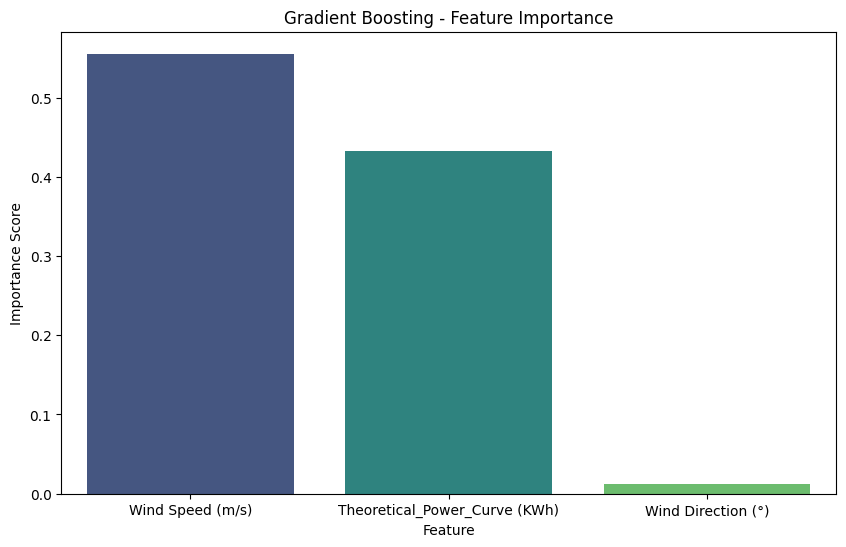


===== XGBoost - Feature Importance Analysis =====
                         Feature  Importance
2  Theoretical_Power_Curve (KWh)    0.737046
0               Wind Speed (m/s)    0.243752
1             Wind Direction (°)    0.019202


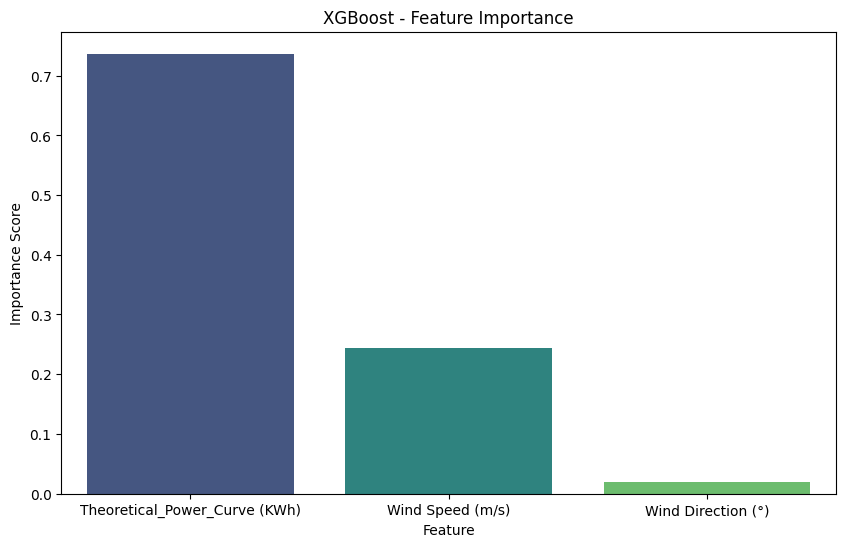

In [74]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
}

# Feature Important Analysis 
for name, model in models.items():
    print(f"\n===== {name} - Feature Importance Analysis =====")
    
    # Model Traing 
    model.fit(X_train, y_train)
    
    # Feature Importance Score
    importances = model.feature_importances_

    # Feature Name 
    feature_names = X.columns
    
    # Decorate the Result in a DataFrame 
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Print the Result 
    print(feature_importance_df)

    # Visualize using a Barchart 
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='Importance', data=feature_importance_df, palette='viridis')
    plt.title(f'{name} - Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.show()

Logistic Regression Feature Importance:
                         Feature  Importance
0               Wind Speed (m/s)    8.506714
2  Theoretical_Power_Curve (KWh)    4.743575
1             Wind Direction (°)    0.112892


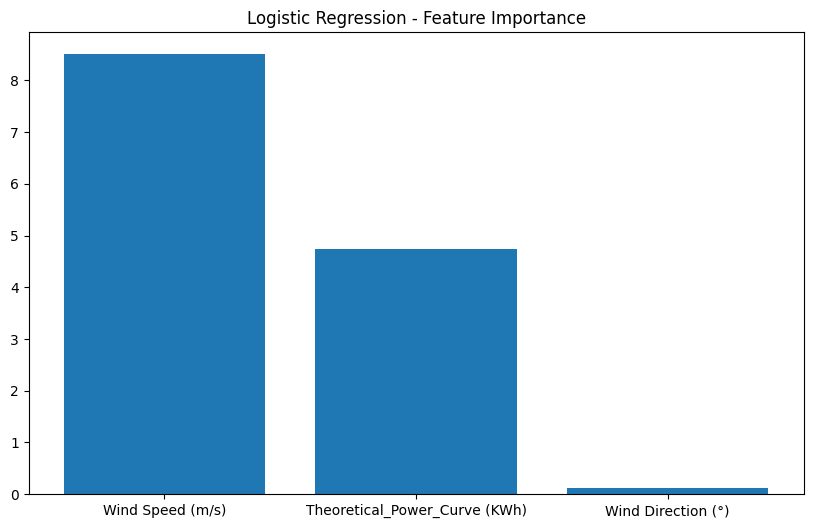

MLP Feature - Importance (approx):
                         Feature  Importance
0               Wind Speed (m/s)   30.458881
2  Theoretical_Power_Curve (KWh)   28.320507
1             Wind Direction (°)   18.876138


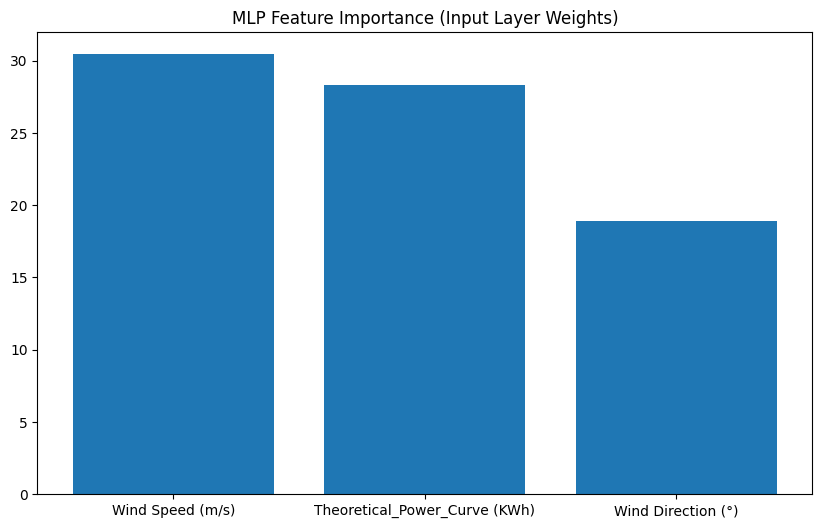

In [75]:

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Assume X_train is your feature DataFrame, y_train is target
feature_names = X.columns

# -------------------------
# Logistic Regression
# -------------------------
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# Multiclass: coef_ shape = (n_classes, n_features)
lr_importances = np.mean(np.abs(lr_model.coef_), axis=0)  # average across classes

lr_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lr_importances
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance:")
print(lr_df)

# Plot
plt.figure(figsize=(10,6))
plt.bar(lr_df['Feature'], lr_df['Importance'])
plt.title("Logistic Regression - Feature Importance")
plt.show()

# -------------------------
# MLP Classifier
# -------------------------
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Feature importance for MLP: sum of absolute weights from input to first hidden layer
mlp_importances = np.sum(np.abs(mlp_model.coefs_[0]), axis=1)

mlp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mlp_importances
}).sort_values(by='Importance', ascending=False)

print("MLP Feature - Importance (approx):")
print(mlp_df)

# Plot
plt.figure(figsize=(10,6))
plt.bar(mlp_df['Feature'], mlp_df['Importance'])
plt.title("MLP Feature Importance (Input Layer Weights)")
plt.show()


### <font color = 'green'>Hyperparameter Tuning Using GridSearchCV

* Hyperparameters are configuration settings that are external to the model and whose values cannot be estimated from the data. These parameters, such as the number of trees in a Random Forest (`n_estimators`) or the learning rate in a Gradient Boosting model, significantly influence a model's performance and can lead to either underfitting or overfitting if not chosen carefully.

* To find the optimal combination of hyperparameters, we employ a technique called **Grid Search with Cross-Validation**. The `GridSearchCV` function from scikit-learn systematically works through multiple combinations of parameter values, specified in a parameter grid. For each combination, it trains the model and evaluates its performance using a cross-validation strategy.

* The model is then trained and evaluated on a held-out test set to get its final performance. This rigorous process ensures that the chosen model configuration is robust and provides the best possible performance on unseen data.

In [76]:
print("Starting Hyperparameter Tuning for Random Forest...")

# Create the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_tuned = best_rf_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"\nAccuracy of the best tuned Random Forest model on test set: {tuned_accuracy:.4f}")



Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=  13.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=  13.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   4

In [77]:
y_pred_tuned = best_rf_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_report = classification_report(y_test, y_pred_tuned, target_names=le.classes_)

print("===== Final Evaluation of Tuned Random Forest  =====")
print(f"Final Accuracy: {tuned_accuracy:.4f}")
print("Final Classification Report:")
print(tuned_report)

===== Final Evaluation of Tuned Random Forest  =====
Final Accuracy: 0.9335
Final Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.97      0.95      3369
         low       0.98      0.88      0.93      3369
      medium       0.90      0.95      0.92      3368

    accuracy                           0.93     10106
   macro avg       0.94      0.93      0.93     10106
weighted avg       0.94      0.93      0.93     10106



In [78]:
print("Starting Hyperparameter Tuning for Gradient Boosting...")

# Define the parameter grid
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the model and GridSearchCV
gb_model = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid_gb,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_gb.fit(X_train, y_train)

# Get the best model
best_gb_model = grid_search_gb.best_estimator_

# Evaluate on the test set
y_pred_gb = best_gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_report = classification_report(y_test, y_pred_gb, target_names=le.classes_)

print("\nBest parameters for Gradient Boosting: ", grid_search_gb.best_params_)
print(f"Final Accuracy on test set: {gb_accuracy:.4f}")
print("Final Classification Report on test set:")
print(gb_report)

Starting Hyperparameter Tuning for Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  22.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  22.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  22.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  44.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  32.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  44.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  44.5s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  32.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  32.8s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=100; total time=  43.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=

In [79]:
print("\nStarting Hyperparameter Tuning for XGBoost...")

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the model and GridSearchCV
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate on the test set
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=le.classes_)

print("\nBest parameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search_xgb.best_score_))
print(f"Final Accuracy on test set: {xgb_accuracy:.4f}")
print("Final Classification Report on test set:")
print(xgb_report)


Starting Hyperparameter Tuning for XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   1.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   1.4s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   1.4s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=100; total time=   1.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   2.7s
[

In [80]:
print("Starting Hyperparameter Tuning for Logistic Regression...")

# Define the parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize the model and GridSearchCV
lr_model = LogisticRegression(random_state=42, max_iter=1000)
grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_lr.fit(X_train, y_train)

# Get the best model
best_lr_model = grid_search_lr.best_estimator_

# Evaluate on the test set
y_pred_lr = best_lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_report = classification_report(y_test, y_pred_lr, target_names=le.classes_)

print("\nBest parameters for Logistic Regression: ", grid_search_lr.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search_lr.best_score_))
print(f"Final Accuracy on test set: {lr_accuracy:.4f}")
print("Final Classification Report on test set:")
print(lr_report)

Starting Hyperparameter Tuning for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.1s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.1s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.1s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.2s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.1s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ..............................C=1, solver=liblinear; total time=   0.1s
[CV] END ................................C=0.1, solver=lbfgs; total time

In [81]:
print("\nStarting Hyperparameter Tuning for MLP Classifier...")

# Define the parameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.01, 0.1]
}

# Initialize the model and GridSearchCV
mlp_model = MLPClassifier(random_state=42, max_iter=2000)
grid_search_mlp = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid_mlp,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Perform Grid Search
grid_search_mlp.fit(X_train, y_train)

# Get the best model
best_mlp_model = grid_search_mlp.best_estimator_

# Evaluate on the test set
y_pred_mlp = best_mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_report = classification_report(y_test, y_pred_mlp, target_names=le.classes_)

print("\nBest parameters for MLP Classifier: ", grid_search_mlp.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search_mlp.best_score_))
print(f"Final Accuracy on test set: {mlp_accuracy:.4f}")
print("Final Classification Report on test set:")
print(mlp_report)


Starting Hyperparameter Tuning for MLP Classifier...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  16.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=  17.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  17.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  18.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=  18.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=sgd; total time=  17.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  21.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  23.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  14.3s
[C

### <font color = 'green'> Cofusion Matrix for Random Forest

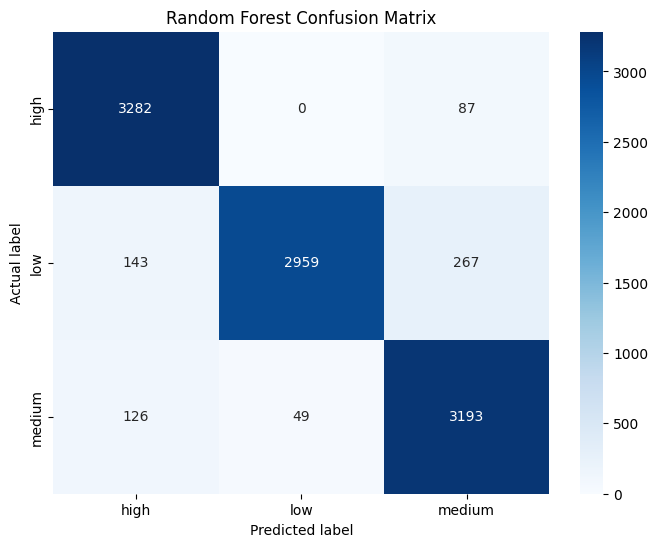

In [82]:
y_pred_rf = best_rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['high', 'low', 'medium'],
            yticklabels=['high', 'low', 'medium'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


### <font color = 'green'> Cofusion Matrix for Gradient Boosting 

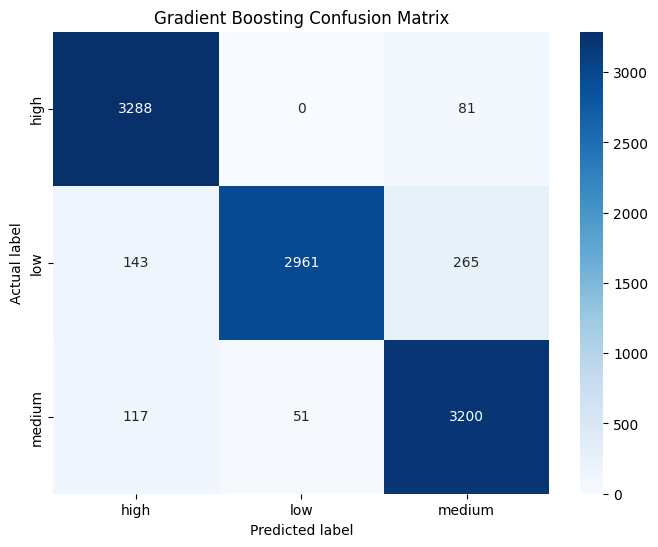

In [83]:
y_pred_gb = best_gb_model.predict(X_test)
cm_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['high', 'low', 'medium'],
            yticklabels=['high', 'low', 'medium'])
plt.title('Gradient Boosting Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


### <font color = 'green'> Cofusion Matrix for XGBoost

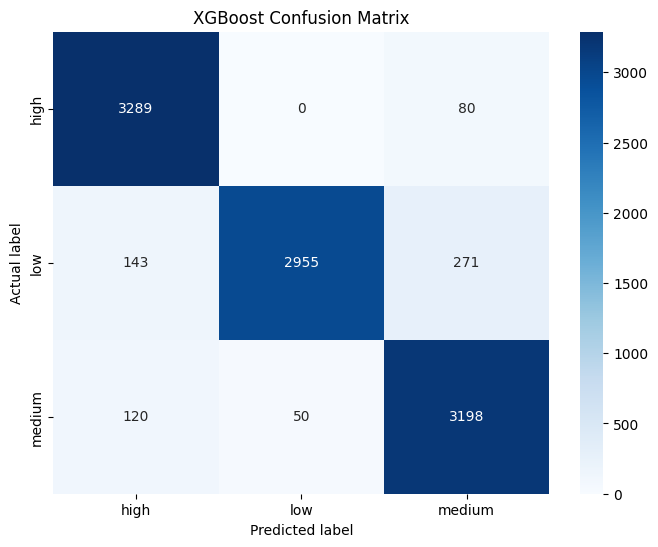

In [84]:
y_pred_xgb = best_xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['high', 'low', 'medium'],
            yticklabels=['high', 'low', 'medium'])
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### <font color = 'green'> Cofusion Matrix for Logistic Regression

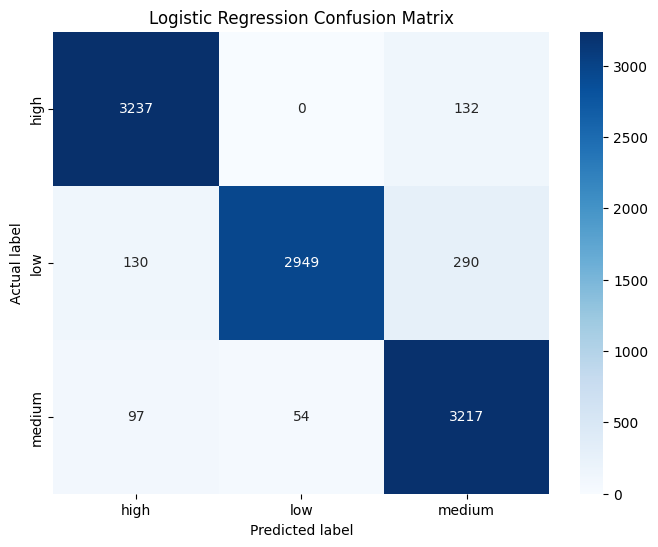

In [85]:
y_pred_lr = best_lr_model.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['high', 'low', 'medium'],
            yticklabels=['high', 'low', 'medium'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


### <font color = 'green'> Cofusion Matrix for MLP

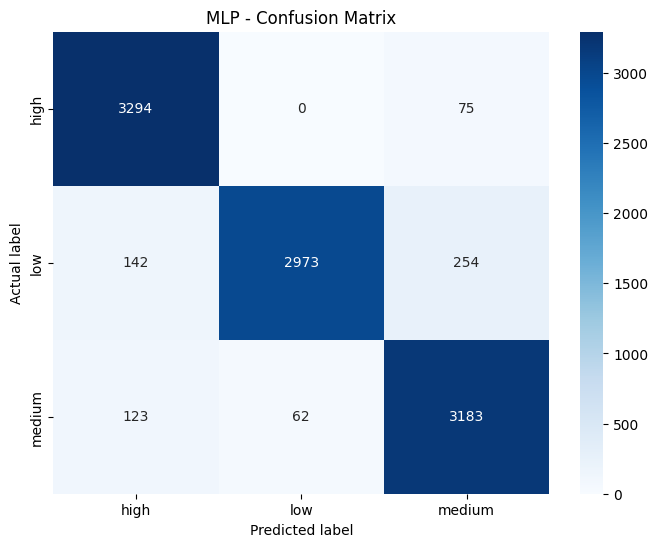

In [86]:
y_pred_mlp = best_mlp_model.predict(X_test)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['high', 'low', 'medium'],
            yticklabels=['high', 'low', 'medium'])
plt.title('MLP - Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### <font color = 'green'> Accuracy Comparison 

The vertical comparison plot has been created and saved as 'model_comparison_vertical.png'.


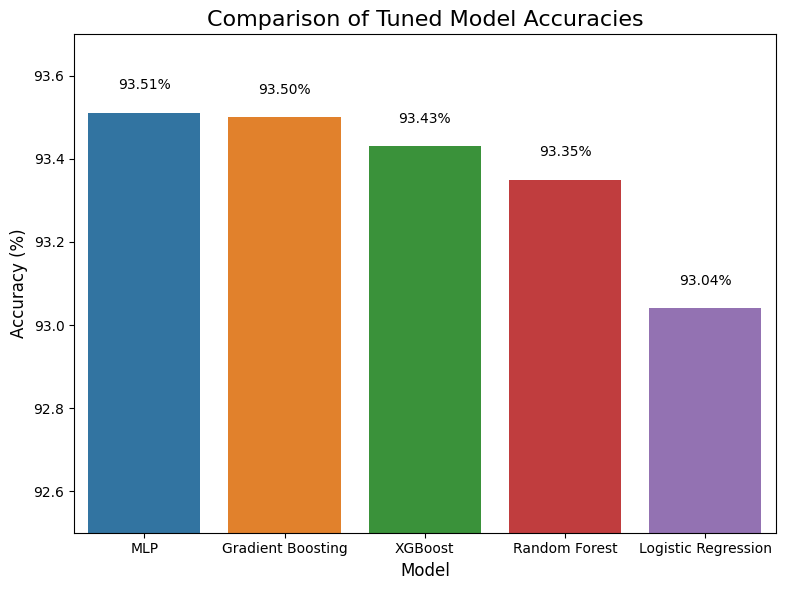

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Final accuracy scores from the previous analysis
tuned_mlp_accuracy = 0.9351
tuned_gb_accuracy = 0.9350
tuned_xgb_accuracy = 0.9343
tuned_rf_accuracy = 0.9335
tuned_lr_accuracy = 0.9304

# Create a DataFrame for plotting, multiplying by 100 for percentages
results = {
    'Model': ['MLP', 'Gradient Boosting', 'XGBoost', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [tuned_mlp_accuracy * 100, tuned_gb_accuracy * 100, tuned_xgb_accuracy * 100,
                 tuned_rf_accuracy * 100, tuned_lr_accuracy * 100]
}

results_df = pd.DataFrame(results)

# Sort the DataFrame by accuracy for a better plot
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# Create the vertical bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=results_df_sorted)

# Add the accuracy value on each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('Comparison of Tuned Model Accuracies', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(92.5, 93.7) # Adjusted y-axis for percentage scale
plt.tight_layout()

# Save the plot to a file
plt.savefig('model_comparison_vertical.png')

print("The vertical comparison plot has been created and saved as 'model_comparison_vertical.png'.")

The vertical comparison plot has been created and saved as 'model_comparison_vertical.png'.


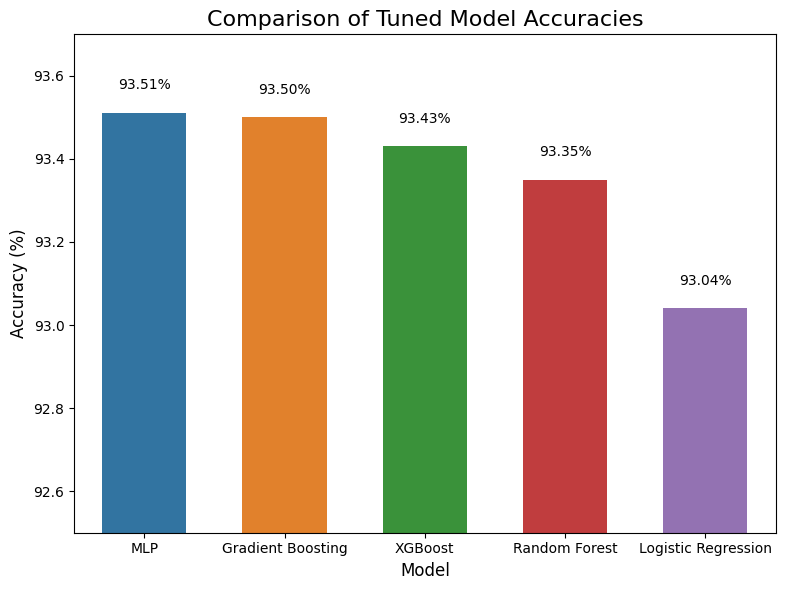

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Final accuracy scores from the previous analysis
tuned_mlp_accuracy = 0.9351
tuned_gb_accuracy = 0.9350
tuned_xgb_accuracy = 0.9343
tuned_rf_accuracy = 0.9335
tuned_lr_accuracy = 0.9304

# Create a DataFrame for plotting, multiplying by 100 for percentages
results = {
    'Model': ['MLP', 'Gradient Boosting', 'XGBoost', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [tuned_mlp_accuracy * 100, tuned_gb_accuracy * 100, tuned_xgb_accuracy * 100,
                 tuned_rf_accuracy * 100, tuned_lr_accuracy * 100]
}

results_df = pd.DataFrame(results)

# Sort the DataFrame by accuracy for a better plot
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# Create the vertical bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=results_df_sorted)

# Manually adjust the width of each bar
for bar in ax.patches:
    # Get the current width of the bar
    current_width = bar.get_width()
    # Get the current x position
    current_x = bar.get_x()
    
    # Set the new width (e.g., 0.5 for a narrower bar)
    new_width = 0.6  
    
    # Calculate the new x position to keep the bar centered
    new_x = current_x + (current_width - new_width) / 2
    
    # Set the new width and x position
    bar.set_width(new_width)
    bar.set_x(new_x)

# Add the accuracy value on each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('Comparison of Tuned Model Accuracies', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(92.5, 93.7) # Adjusted y-axis for percentage scale
plt.tight_layout()

# Save the plot to a file
plt.savefig('model_comparison_vertical.png')

print("The vertical comparison plot has been created and saved as 'model_comparison_vertical.png'.")

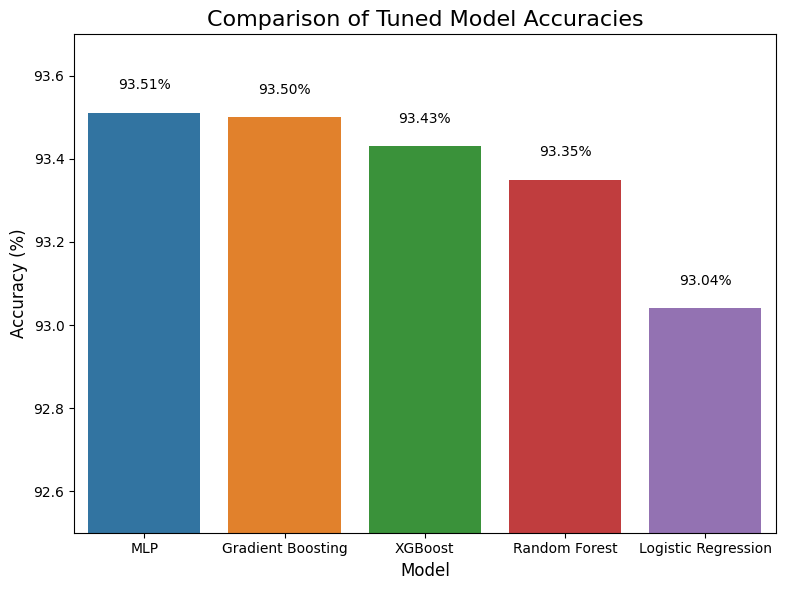

The percentage comparison plot has been created, shown, and saved as 'model_comparison_percentage.png'.


In [95]:
# Create the vertical bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=results_df_sorted)

# Add the accuracy value on top of each bar
for p in ax.patches:
    height = p.get_height()  # Use height for vertical bars
    plt.text(p.get_x() + p.get_width() / 2, height + 0.05, f'{height:.2f}%', ha='center', va='bottom')

plt.title('Comparison of Tuned Model Accuracies', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(92.5, 93.7)  # Adjust y-axis for percentage scale
plt.tight_layout()

# Save the plot to a file
plt.savefig('model_comparison_percentage.png')

# Show the plot
plt.show()

print("The percentage comparison plot has been created, shown, and saved as 'model_comparison_percentage.png'.")


### <font color = 'green'> Feature Importance Analysis for Tuned Models 

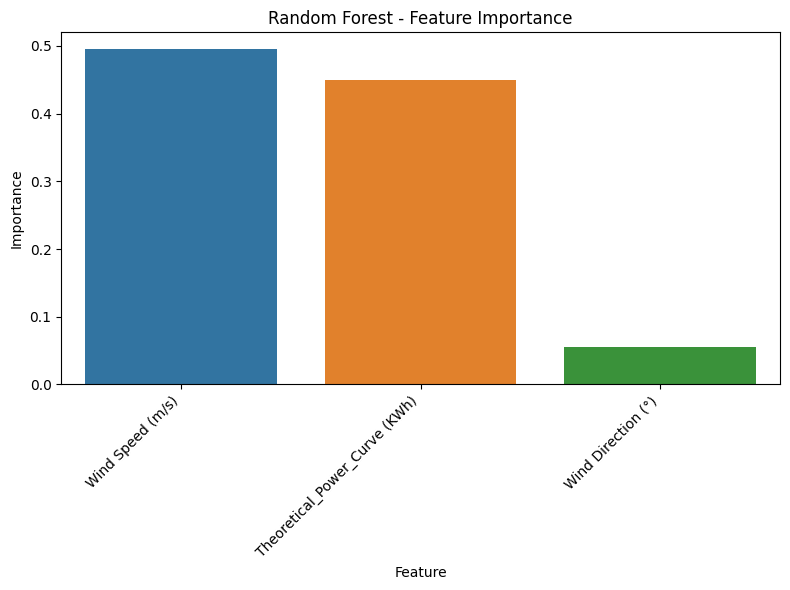

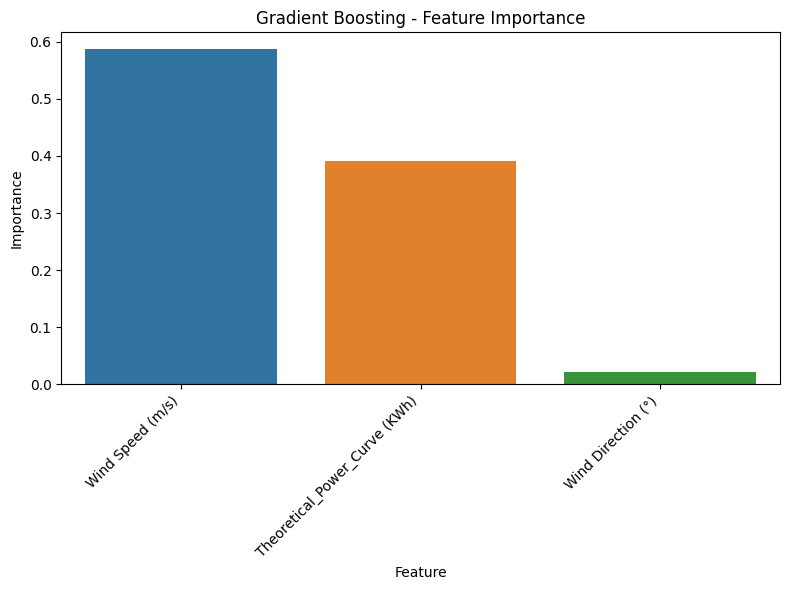

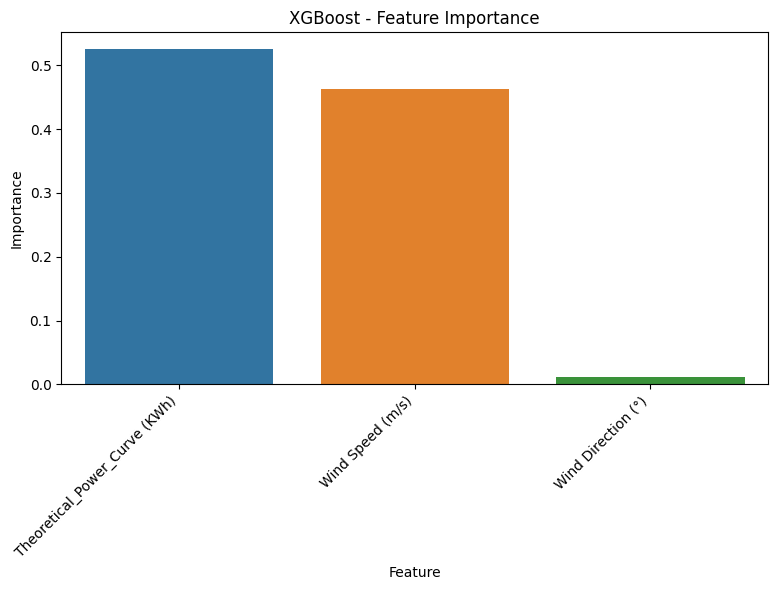

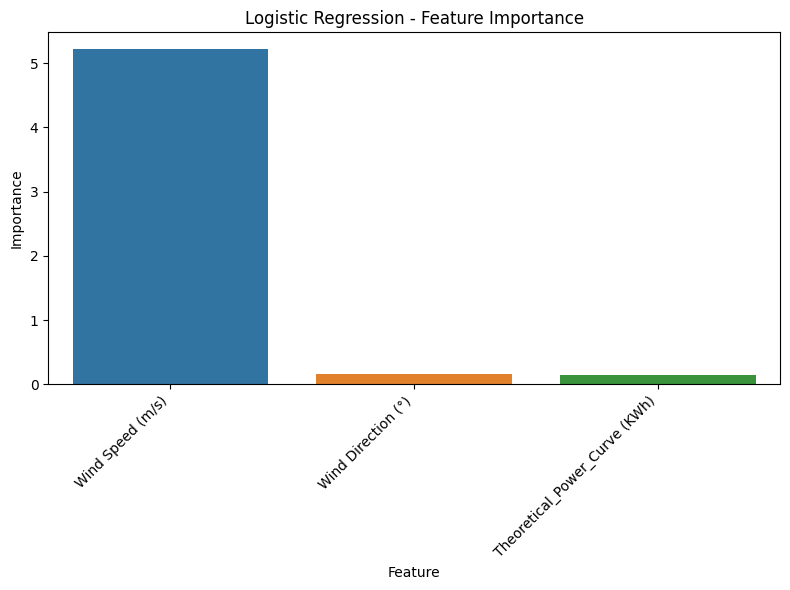

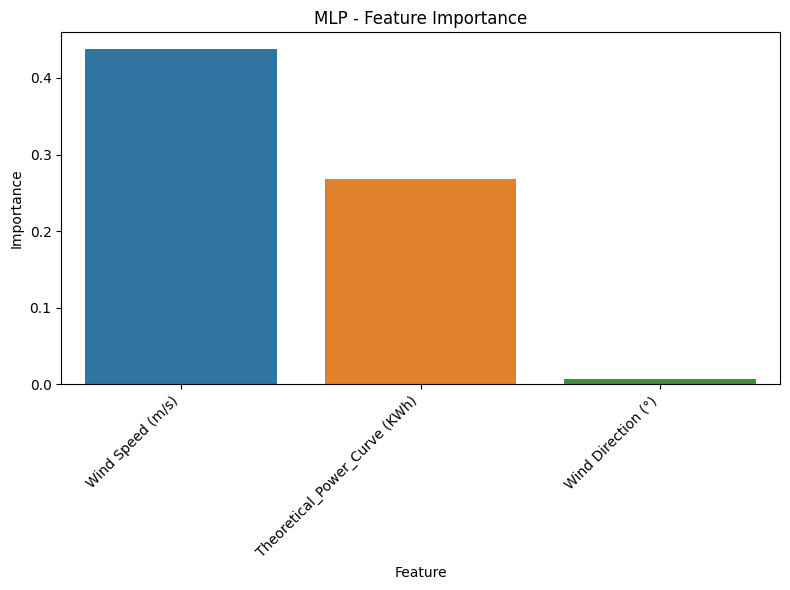

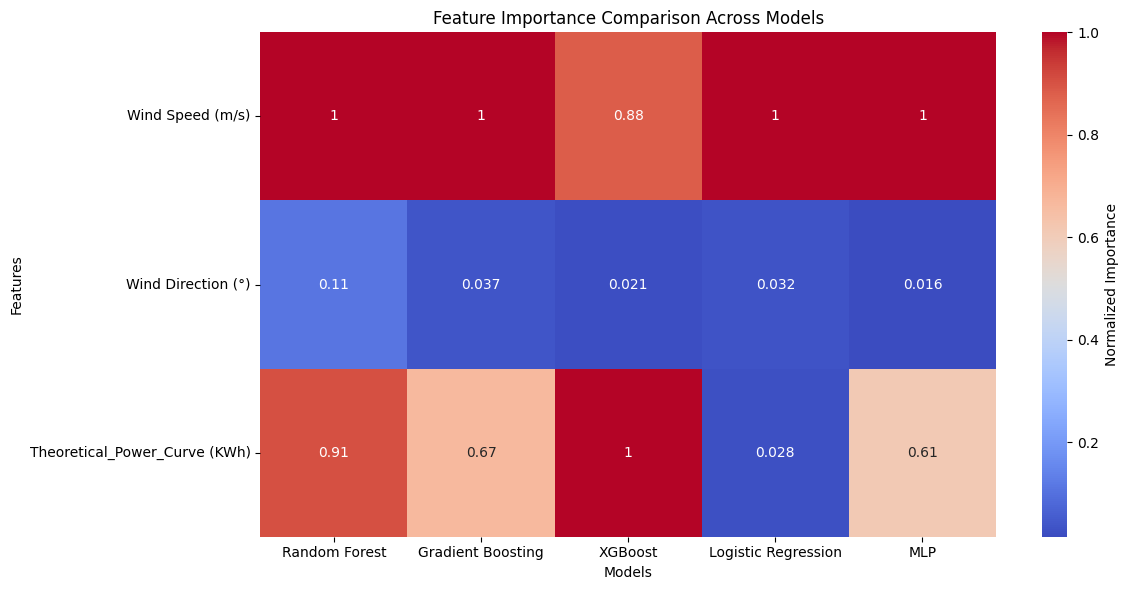

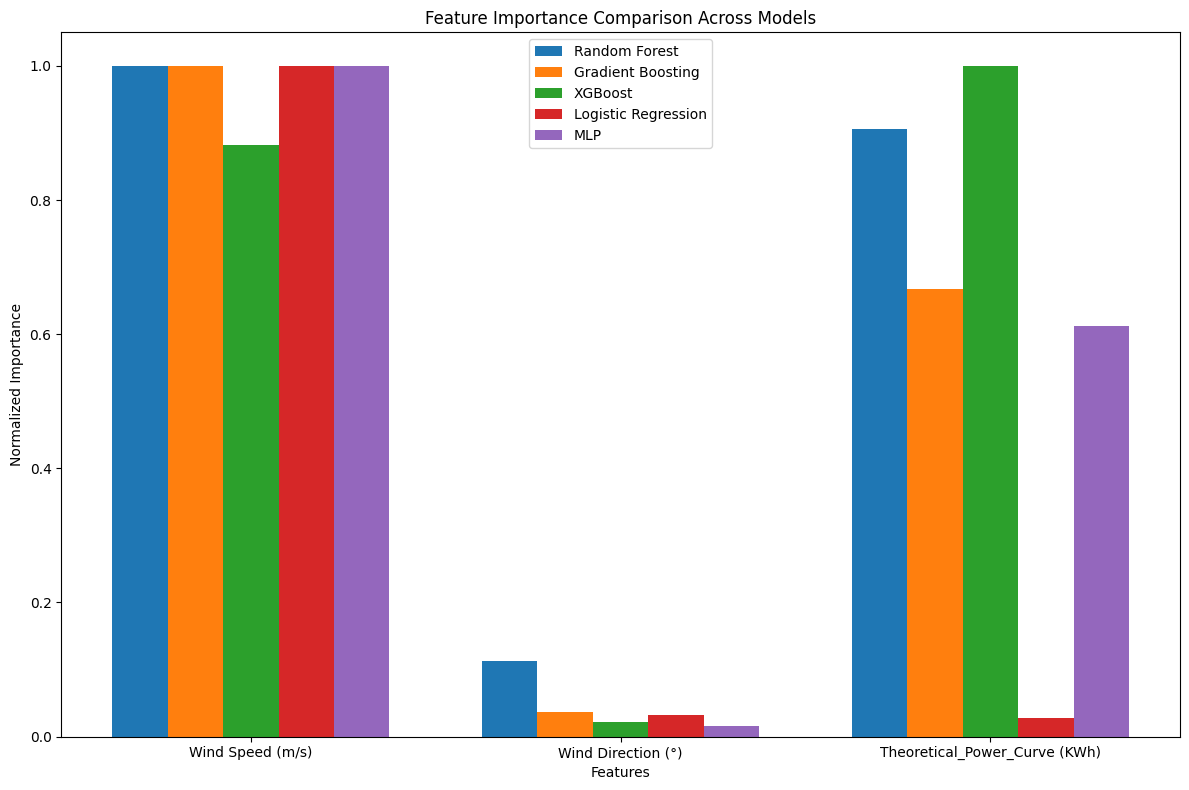


Random Forest Feature Importances:
                      Feature  Importance
             Wind Speed (m/s)    0.495377
Theoretical_Power_Curve (KWh)    0.449106
           Wind Direction (°)    0.055517

Gradient Boosting Feature Importances:
                      Feature  Importance
             Wind Speed (m/s)    0.586802
Theoretical_Power_Curve (KWh)    0.391311
           Wind Direction (°)    0.021887

XGBoost Feature Importances:
                      Feature  Importance
Theoretical_Power_Curve (KWh)    0.525449
             Wind Speed (m/s)    0.463284
           Wind Direction (°)    0.011267

Logistic Regression Feature Importances:
                      Feature  Importance
             Wind Speed (m/s)    5.219003
           Wind Direction (°)    0.169338
Theoretical_Power_Curve (KWh)    0.143825

MLP Feature Importances:
                      Feature  Importance
             Wind Speed (m/s)    0.437572
Theoretical_Power_Curve (KWh)    0.267880
           Wind Direction (°

In [101]:
from sklearn.inspection import permutation_importance

best_rf_model.fit(X_train, y_train)
best_gb_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)
best_lr_model.fit(X_train, y_train)
best_mlp_model.fit(X_train, y_train)

# -----------------------------
# 2. Feature importance
# -----------------------------
all_feature_importance = {}
feature_names = X.columns

# Random Forest
all_feature_importance['Random Forest'] = best_rf_model.feature_importances_

# Gradient Boosting
all_feature_importance['Gradient Boosting'] = best_gb_model.feature_importances_

# XGBoost
all_feature_importance['XGBoost'] = best_xgb_model.feature_importances_

# Logistic Regression (absolute coefficients)
all_feature_importance['Logistic Regression'] = np.abs(best_lr_model.coef_[0])

# MLP (Permutation Importance)
mlp_perm = permutation_importance(best_mlp_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
all_feature_importance['MLP'] = mlp_perm.importances_mean

# -----------------------------
# 3. Individual feature importance plots
# -----------------------------
for model_name, importances in all_feature_importance.items():
    df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df = df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='Feature', y='Importance', data=df)
    plt.title(f'{model_name} - Feature Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. Combined heatmap for comparison
# -----------------------------
combined_df = pd.DataFrame(all_feature_importance, index=feature_names)
combined_df = combined_df / combined_df.max()  # normalize for comparison

plt.figure(figsize=(12,6))
sns.heatmap(combined_df, annot=True, cmap='coolwarm', cbar_kws={'label':'Normalized Importance'})
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# 5. Combined grouped bar plot for comparison

models = combined_df.columns
features = combined_df.index
x = np.arange(len(features))  # feature locations
width = 0.15  # width of each bar

plt.figure(figsize=(12,8))

for i, model in enumerate(models):
    plt.bar(x + i*width, combined_df[model], width=width, label=model)

plt.xticks(x + width*(len(models)/2 - 0.5), features,  ha='center')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.title('Feature Importance Comparison Across Models')
plt.legend()
plt.tight_layout()

plt.savefig(r"D:\feature_importance_comparison.png", dpi=300)  # dpi=300 for high quality

plt.show()

# Print feature importance scores in text format
for model_name, importances in all_feature_importance.items():
    print(f"\n{model_name} Feature Importances:")
    df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df = df.sort_values(by='Importance', ascending=False)
    print(df.to_string(index=False))  # print without row numbers
